In [6]:
!source mlproject/bin/activate

In [7]:
pip install pandas numpy matplotlib scikit-learn seaborn jupyterlab

  Using cached jupyterlab-4.5.4-py3-none-any.whl.metadata (16 kB)
  Using cached async_lru-2.1.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached jupyter_lsp-2.3.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.17.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyterlab_server-2.28.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached argon2_cffi-25.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached jupyter_events-0.12.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached jupyter_server_terminals-0.5.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached nbconvert-7.17.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached prometheus_client-0.24.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached send2trash-2.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached termi

In [8]:
pip install imblearn xgboost

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached xgboost-3.2.0-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached imbalanced_learn-0.14.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached sklearn_compat-0.1.5-py3-none-any.whl.metadata (20 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached xgboost-3.2.0-py3-none-macosx_12_0_arm64.whl (2.3 MB)
Using cached imbalanced_learn-0.14.1-py3-none-any.whl (235 kB)
Using cached sklearn_compat-0.1.5-py3-none-any.whl (20 kB)

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

# For feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import Lasso, LogisticRegression

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# For modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Phase 1: Exploratory Data Analysis 

In [10]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully from URL!")
except:
    print("Failed to load from URL. Please download the dataset manually.")
    print("Download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    # Uncomment and use local file if download is needed
    # df = pd.read_csv('Telco-Customer-Churn.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Dataset loaded successfully from URL!

Dataset Shape: (7043, 21)
Rows: 7043, Columns: 21


In [11]:
# Basic Information about the dataset
print("="*80)
print("DATASET BASIC INFORMATION")
print("="*80)

# Display first few rows
print("\n📊 First 5 rows:")
print(df.head())

print("\n" + "="*80)
print("\n📋 Dataset Info:")
print(df.info())

print("\n" + "="*80)
print("\n📈 Statistical Summary:")
print(df.describe())

print("\n" + "="*80)
print("\n🔍 Data Types:")
print(df.dtypes.value_counts())

print("\n" + "="*80)
print("\n📌 Column Names:")
print(df.columns.tolist())

DATASET BASIC INFORMATION

📊 First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

DATA QUALITY CHECK

🔄 Duplicate Rows: 0

❓ Missing Values per Column:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
✅ No missing values detected!


🎯 Target Variable Distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

📊 Proportion:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


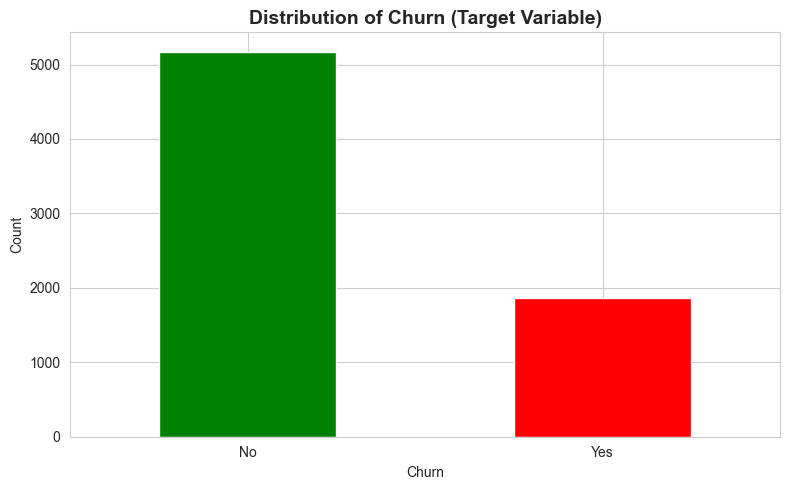

In [12]:
# Check for duplicates and missing values
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

print(f"\n🔄 Duplicate Rows: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    print(f"Removing {df.duplicated().sum()} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New shape: {df.shape}")

print(f"\n❓ Missing Values per Column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values(by='Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✅ No missing values detected!")

print("\n" + "="*80)
print("\n🎯 Target Variable Distribution (Churn):")
print(df['Churn'].value_counts())
print("\n📊 Proportion:")
print(df['Churn'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Churn (Target Variable)', fontsize=14, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Univariate Analysis 

In [13]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable and customerID from lists if present
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'customerID' in numerical_cols:
    numerical_cols.remove('customerID')

print(f"📊 Numerical Columns ({len(numerical_cols)}): {numerical_cols}")
print(f"📋 Categorical Columns ({len(categorical_cols)}): {categorical_cols}")

📊 Numerical Columns (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
📋 Categorical Columns (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


HISTOGRAMS FOR NUMERICAL VARIABLES


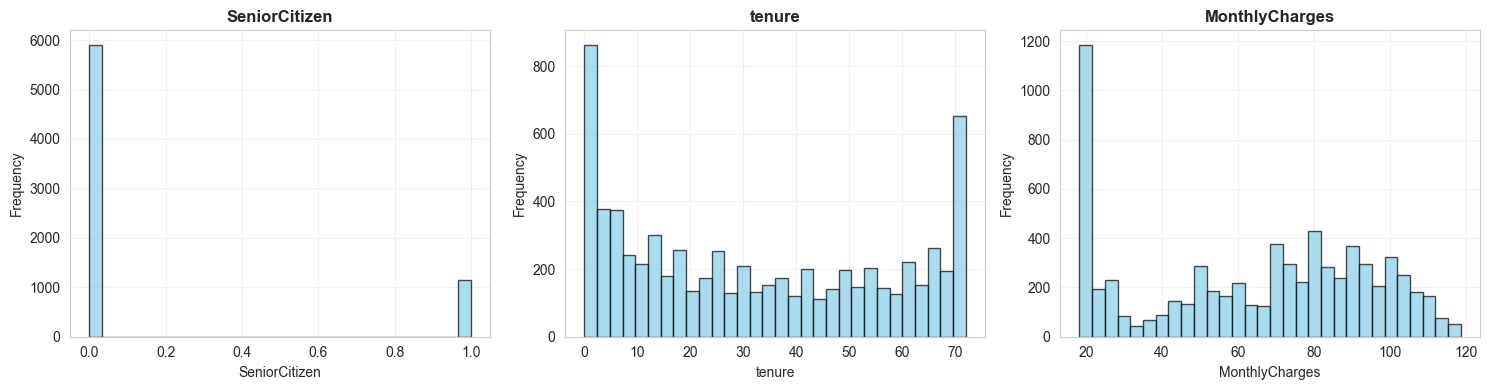


📈 Statistics for Numerical Variables:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [14]:
# Histograms for Numerical Variables
print("="*80)
print("HISTOGRAMS FOR NUMERICAL VARIABLES")
print("="*80)

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display statistics for numerical variables
print("\n📈 Statistics for Numerical Variables:")
print(df[numerical_cols].describe())

BAR PLOTS FOR CATEGORICAL VARIABLES


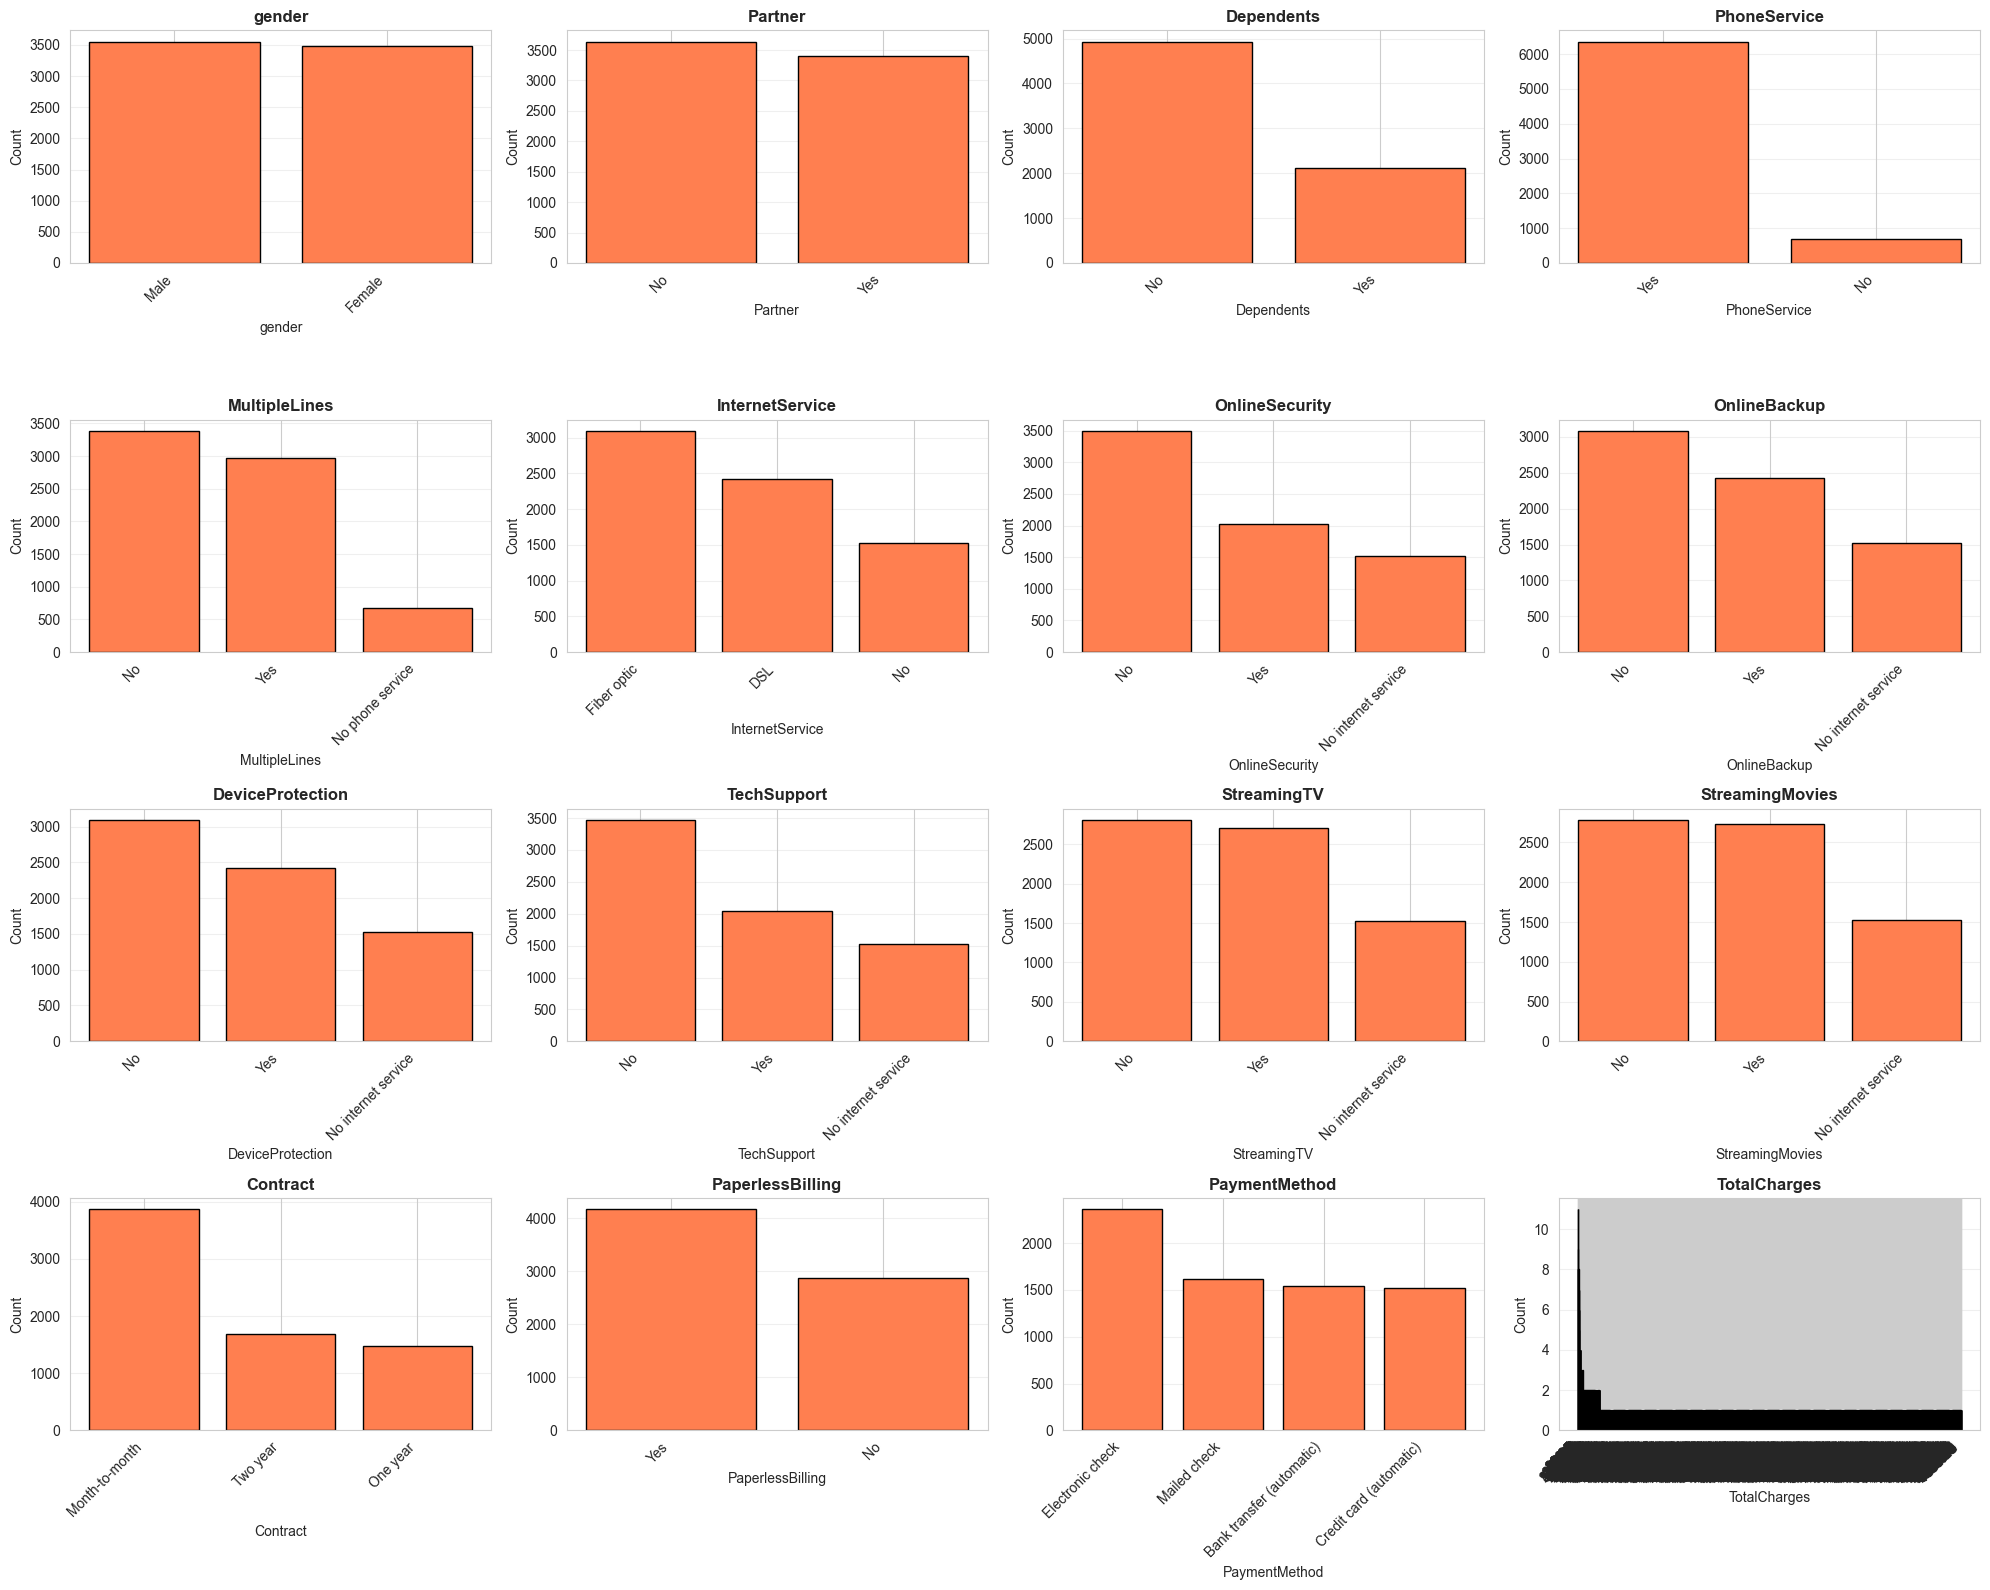


📊 Unique values per categorical variable:
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values


In [15]:
# Bar Plots for Categorical Variables
print("="*80)
print("BAR PLOTS FOR CATEGORICAL VARIABLES")
print("="*80)

# Plot first batch of categorical variables
n_cols = 4
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        value_counts = df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='coral', edgecolor='black')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].grid(alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Unique values per categorical variable:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

### Bivariate Analysis and Correlation

CORRELATION HEATMAP


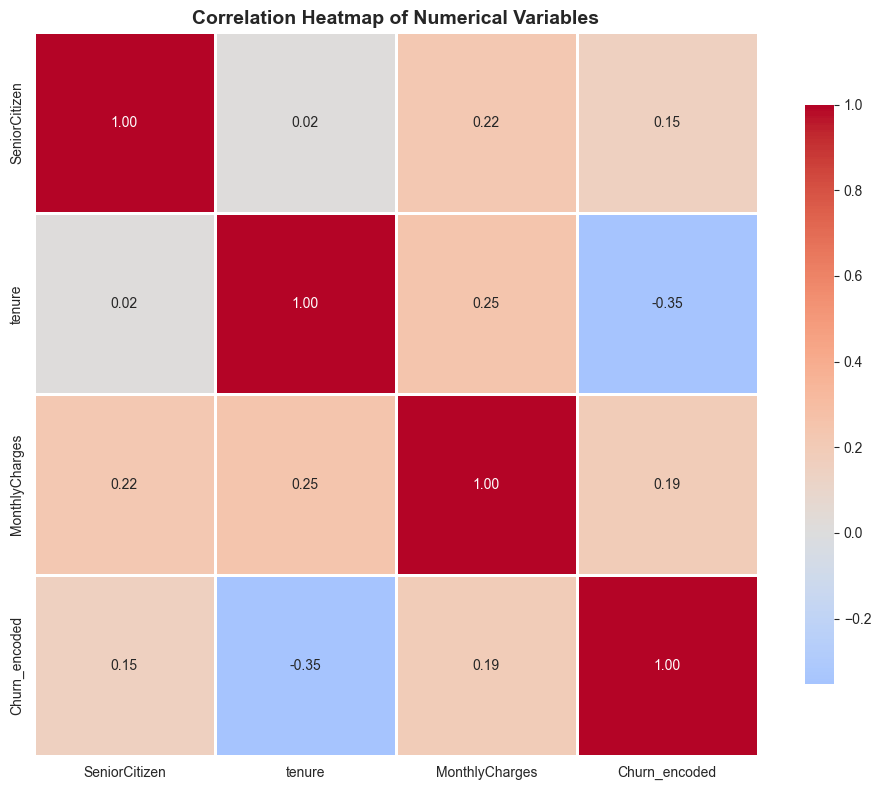


🎯 Correlation with Churn (sorted by absolute value):
tenure           -0.352229
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Name: Churn_encoded, dtype: float64


In [16]:
# Correlation Heatmap for Numerical Variables
print("="*80)
print("CORRELATION HEATMAP")
print("="*80)

# Create a copy and encode Churn for correlation
df_corr = df.copy()
df_corr['Churn_encoded'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# Select numerical columns including encoded target
corr_cols = numerical_cols + ['Churn_encoded']
correlation_matrix = df_corr[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display correlations with target
print("\n🎯 Correlation with Churn (sorted by absolute value):")
churn_corr = correlation_matrix['Churn_encoded'].drop('Churn_encoded').sort_values(key=abs, ascending=False)
print(churn_corr)

BOXPLOTS: NUMERICAL FEATURES vs CHURN


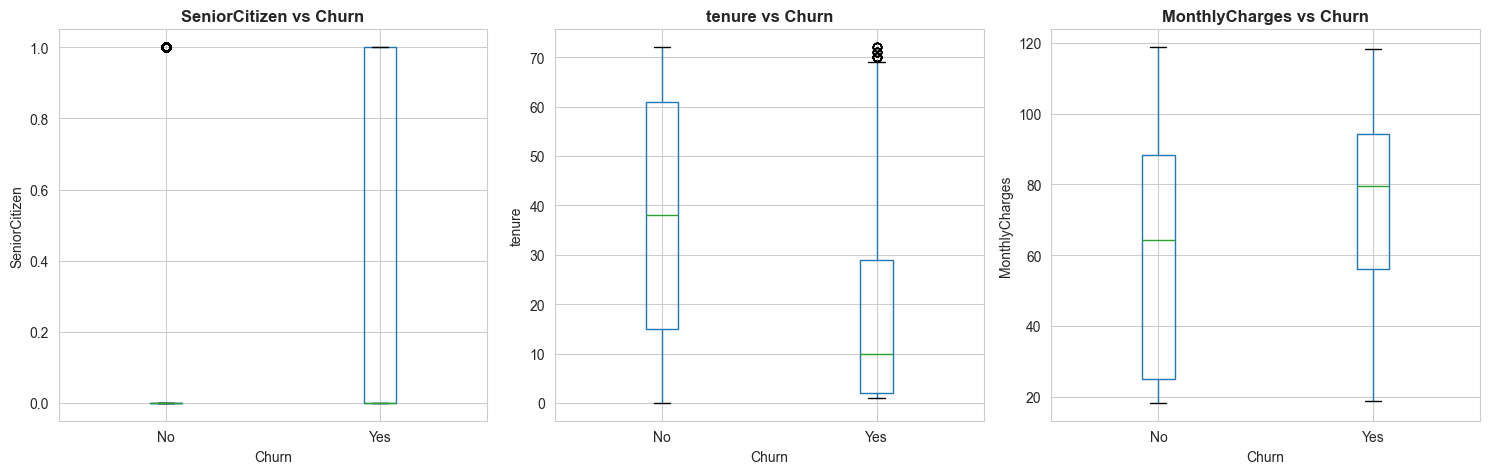


📊 Mean values by Churn status:
       SeniorCitizen     tenure  MonthlyCharges
Churn                                          
No          0.128721  37.569965       61.265124
Yes         0.254682  17.979133       74.441332


In [17]:
# Boxplots: Relationship between Numerical Features and Churn
print("="*80)
print("BOXPLOTS: NUMERICAL FEATURES vs CHURN")
print("="*80)

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 5))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{col} vs Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.suptitle('')  # Remove the default title
plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📊 Mean values by Churn status:")
print(df.groupby('Churn')[numerical_cols].mean())